In [1]:

import os
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import torch
from skimage import io, color
from skimage.transform import resize
from torch.utils.data import Dataset
import torch.nn.functional as F

In [4]:
!pip install seaborn

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [10]:

pip install -U scikit-learn


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 3.7 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/11.0 MB 2.9 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.0 MB 3.3 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.0 MB 3.9 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 4.8 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.0 MB 5.4 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 6.5 MB/s eta 0:00:00


(512, 512, 3)
(512, 512, 3)
(350, 350, 3)
(512, 512, 3)


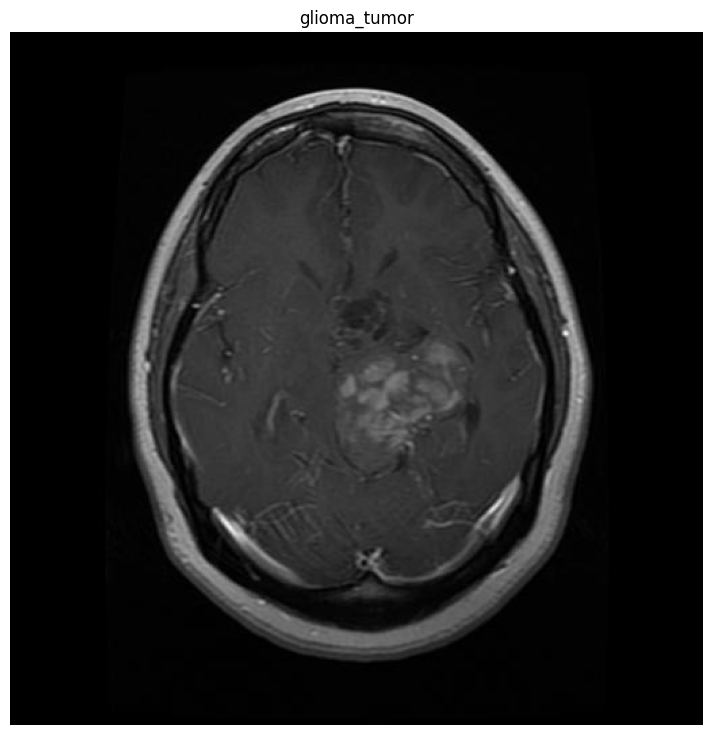

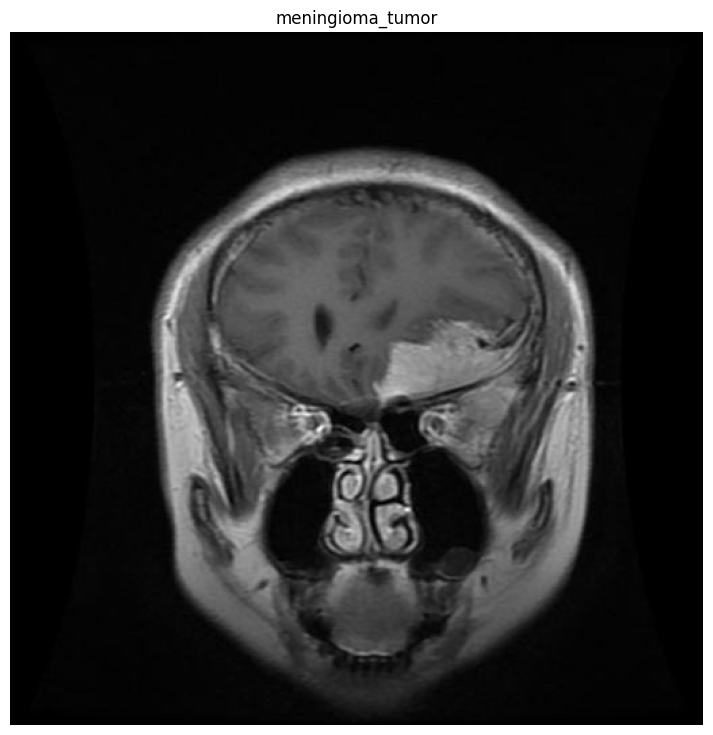

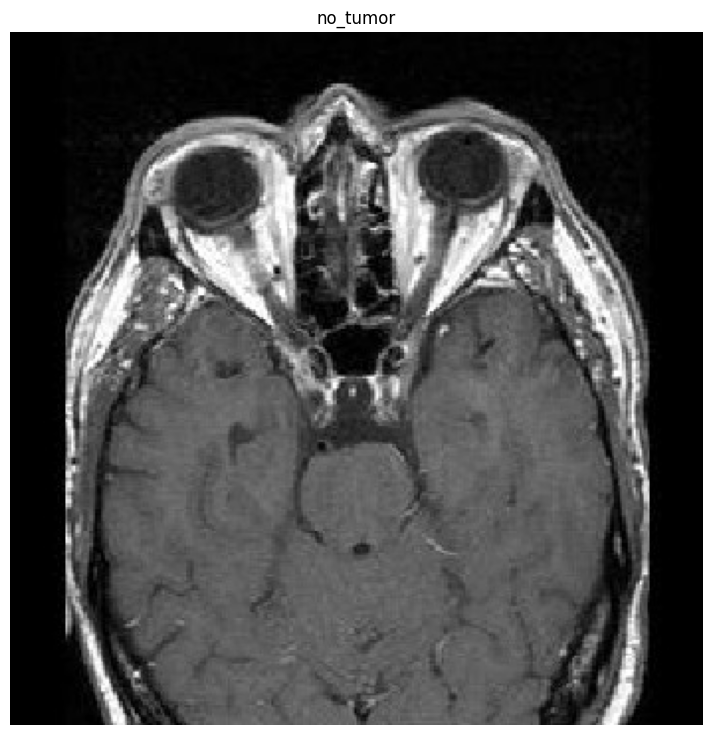

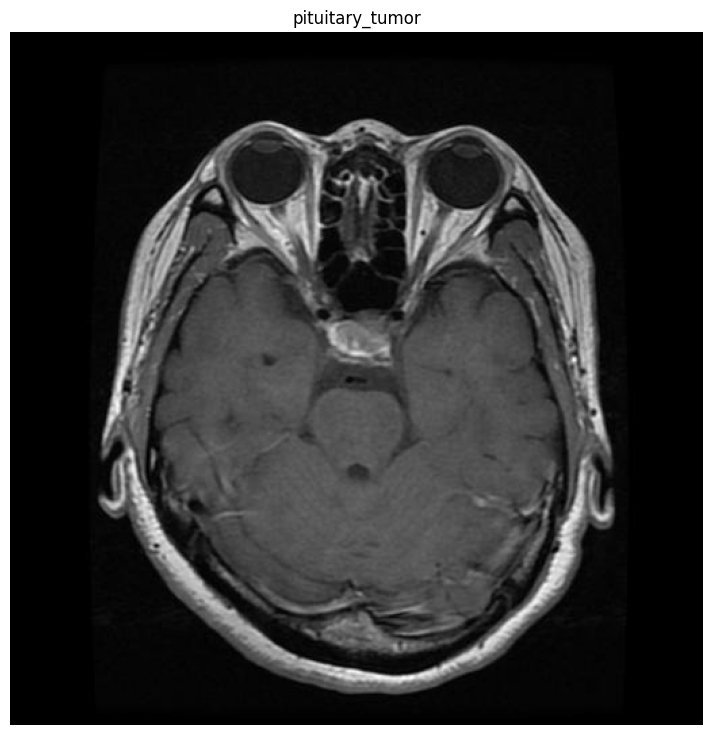

In [2]:
root_dir = 'D:\\stuff\\Datasets\\MRI_brain_tumors'

for Classes in os.listdir(os.path.join(root_dir,'Training')):
    sample_images_path = os.listdir(os.path.join(root_dir,'Training',Classes))
    #print(sample_images_path)
    sample_images = io.imread(os.path.join(root_dir,'Training',Classes,sample_images_path[0]))
    plt.figure(figsize=(9,9))
    plt.title(Classes)
    plt.axis('off')
    plt.imshow(sample_images)
    print(sample_images.shape)
    

In [3]:
import os
import torch
from skimage import io, color
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

# Step 1: Define Preprocessing (Separate Step)
preprocess_transform = transforms.Compose([
    transforms.ToPILImage(),                    # Convert numpy image to PIL for transforms
    transforms.Resize((256, 256)),              # Resize the image
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize with a standard mean and std for grayscale
])

# Step 2: Define Dataset Class without Transformation Logic
class TumorDataset(Dataset):
    def __init__(self, root_dir, mode='Training', fixed_size=(512, 512)):
        self.root_dir = root_dir
        self.mode = mode  
        self.fixed_size = fixed_size
        self.classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        self.image_paths = []
        self.labels = []
        self.num_classes = len(self.classes)

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, mode, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = io.imread(img_path)

        # Check if the image is RGB and convert to grayscale if necessary
        if img.ndim == 3:
            img = color.rgb2gray(img)
        
        # Resize the image to a fixed size
        img = resize(img, self.fixed_size, anti_aliasing=True, preserve_range=True)
        
        # Convert to a tensor
        img_tensor = torch.tensor(img).unsqueeze(0).float()

        # Get the label and apply one-hot encoding
        label = self.labels[idx]
        

        # Return image and label (without transformation)
        return img_tensor, label

# Step 3: Apply Transformations Externally in the DataLoader Pipeline
def apply_transforms(dataset, transform):
    transformed_images = []
    transformed_labels = []

    for img_tensor, label in dataset:
        transformed_img = transform(img_tensor.squeeze())  # Remove the channel dimension for transforms
        transformed_images.append(transformed_img)
        transformed_labels.append(label)
    
    return list(zip(transformed_images, transformed_labels))


# Example usage
root_dir = 'D:\\stuff\\Datasets\\MRI_brain_tumors'

# Initialize datasets
train_dataset = TumorDataset(root_dir=root_dir, mode='Training')
test_dataset = TumorDataset(root_dir=root_dir, mode='Testing')

# Step 4: Apply the transforms externally
transformed_train_dataset = apply_transforms(train_dataset, preprocess_transform)
transformed_test_dataset = apply_transforms(test_dataset, preprocess_transform)

# Convert to DataLoader
train_loader = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=32, shuffle=False)

print('Data preprocessing and loading separated successfully')


Data preprocessing and loading separated successfully


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
device = torch.device('cuda')

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.fc1 = nn.Linear(64 * 64*64, 256)  # Modify based on the image size
        self.fc2 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

model = SimpleCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 10


def train(model, train_loader, optimizer, criterion, epochs):
    torch.cuda.empty_cache()
    accuracy_per_epoch = []
    test_accuracy_per_epoch = []
    
    for epoch in range(epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            predicted_class = torch.argmax(output, dim=1)
            correct = predicted_class.eq(target).sum().item()
            total_samples += target.size(0)
            total_correct += correct

        accuracy = total_correct / total_samples
        accuracy_per_epoch.append(accuracy)
        test_accuracy = evaluate(model, test_loader)
        test_accuracy_per_epoch.append(test_accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}')
    
    return accuracy_per_epoch, test_accuracy_per_epoch


def evaluate(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            predicted_class = torch.argmax(output, dim=1)
            correct += predicted_class.eq(target).sum().item()
            total += target.size(0)
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

def plot_accuracy(train_accuracy, test_accuracy):
    plt.plot(range(1, epochs + 1), train_accuracy, marker='o', label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracy, marker='o', label='Test Accuracy')
    plt.title('Training and Test Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

accuracies, test_accuracies = train(model,train_loader,optimizer,criterion,epochs)


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:38<00:00,  2.33it/s]


Test Accuracy: 0.3680
Epoch [1/10], Loss: 1.1031, Accuracy: 0.5282


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:36<00:00,  2.50it/s]


Test Accuracy: 0.4137
Epoch [2/10], Loss: 0.6936, Accuracy: 0.7244


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.53it/s]


Test Accuracy: 0.5761
Epoch [3/10], Loss: 0.5023, Accuracy: 0.8105


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.54it/s]


Test Accuracy: 0.6497
Epoch [4/10], Loss: 0.4015, Accuracy: 0.8484


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.54it/s]


Test Accuracy: 0.7030
Epoch [5/10], Loss: 0.3076, Accuracy: 0.8826


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.53it/s]


Test Accuracy: 0.6954
Epoch [6/10], Loss: 0.2396, Accuracy: 0.9185


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.54it/s]


Test Accuracy: 0.7208
Epoch [7/10], Loss: 0.1788, Accuracy: 0.9418


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.54it/s]


Test Accuracy: 0.7234
Epoch [8/10], Loss: 0.1343, Accuracy: 0.9568


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.54it/s]


Test Accuracy: 0.7208
Epoch [9/10], Loss: 0.1148, Accuracy: 0.9672


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:35<00:00,  2.53it/s]


Test Accuracy: 0.7259
Epoch [10/10], Loss: 0.0713, Accuracy: 0.9801


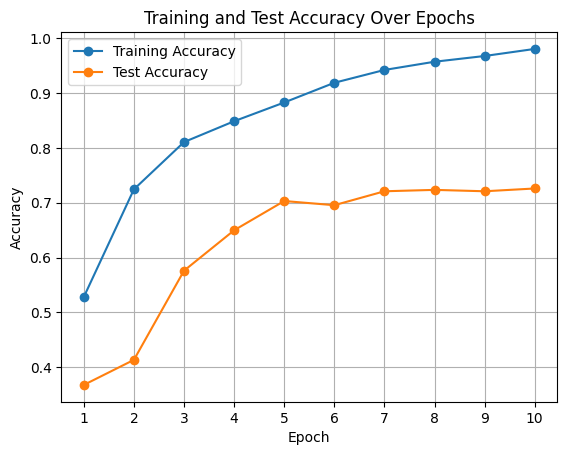

In [24]:
plot_accuracy(accuracies,test_accuracies)

In [25]:
evaluate(model,test_loader)

Test Accuracy: 0.7259


0.7258883248730964

In [18]:
vgg16_model = torchvision.models.vgg16()

print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
for params in vgg16_model.parameters():
    params.require_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 512),
    nn.ReLU(),
    nn.Dropout(0.15),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.15),
    nn.Linear(128, 4)  
)


with torch.no_grad():
    vgg16_model.features[0].weight[:] = vgg16_model.features[0].weight.mean(dim=1, keepdim=True)
vgg16_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

vgg16_model.to(device)
epochs = 5
train(vgg16_model,train_loader,optimizer,criterion,epochs=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [33:40<00:00, 22.45s/it]


Test Accuracy: 0.1878
Epoch [1/1], Loss: 1.3887, Accuracy: 0.2854


([0.28536585365853656], [0.18781725888324874])